In [2]:
	
import os
import re
import sys
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import tensorflow as tf
from collections import defaultdict
from scipy.special import softmax
from scipy.stats import entropy
from scipy.signal import spectrogram
from scipy.signal import spectrogram, find_peaks
from scipy.stats import entropy
import gc

In [3]:
# -------------------- Load GPU Delegate --------------------
delegate = None
try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    from tensorflow import lite as tflite

try:
    delegate = tf.lite.experimental.load_delegate("libtensorflowlite_gpu_delegate.so")
    print("GPU delegate loaded successfully.")
except Exception as e:
    print("GPU delegate not available:", e)

# -------------------- Patch Interpreter BEFORE importing wrapper --------------------
if not hasattr(tflite, "_original_interpreter"):
    tflite._original_interpreter = tflite.Interpreter

    def Interpreter_with_delegate(*args, **kwargs):
        if delegate is not None:
            kwargs["experimental_delegates"] = [delegate]
        return tflite._original_interpreter(*args, **kwargs)

    tflite.Interpreter = Interpreter_with_delegate

Exception ignored in: <function Delegate.__del__ at 0x0000028D33B21940>
Traceback (most recent call last):
  File "c:\Users\DELL\anaconda3\envs\an\Lib\site-packages\tensorflow\lite\python\interpreter.py", line 121, in __del__
    if self._library is not None:
       ^^^^^^^^^^^^^
AttributeError: 'Delegate' object has no attribute '_library'


GPU delegate not available: Could not find module 'libtensorflowlite_gpu_delegate.so' (or one of its dependencies). Try using the full path with constructor syntax.


In [10]:
DATASET_PATH = r"E:\monitoring_data\sound_recordings\spot_4_yoga_spot\07062025-21062025_5R5W\recordings"
STATIC_NOISE_PATH = r"E:\projects\acoustic_biodiversity\static_noise.wav"
TARGET_SR = 48000
OUTPUT_CSV = r"E:\monitoring_data\sound_recordings\spot_4_yoga_spot\07062025-21062025_5R5W\newindices.csv"

In [6]:
def extract_year_month_date_hour_and_minute(filename):
    """Extracts hour and minute from filenames like '2MM07103_20250330_143000.wav'."""
    match_date = re.search(r'_(\d{8})_', filename)
    match = re.search(r'_(\d{6})\.wav$', filename)
    if match and match_date:
        time_str = match.group(1)
        date_str = match_date.group(1)
        year = date_str[:4]
        month = date_str[4:6]
        date = date_str[6:]
        hour = int(time_str[:2])
        minute = int(time_str[2:4])
        return year, month, date, hour, minute
    return None, None, None, None, None

def remove_static_noise(audio, noise_ref, sr=TARGET_SR, snr_db=18):
    """
    Combines time-domain noise subtraction and spectral gating to remove static noise.
    
    1. Time-Domain Subtraction:  
       - The noise reference is padded (using 'wrap' mode) to match the audio length.
       - Its power is scaled (using the desired SNR) and subtracted from the audio.
       
    2. Spectral Gating:  
       - The resulting audio is transformed into the frequency domain using STFT.
       - A noise threshold is computed from the noise reference (via its STFT).
       - Frequency bins with energy below the threshold are zeroed out.
       - The audio is reconstructed using the inverse STFT.
    """
    # --- Time-Domain Subtraction ---
    if len(noise_ref) > len(audio):
        noise_ref = noise_ref[:len(audio)]
    else:
        noise_ref = np.pad(noise_ref, (0, len(audio) - len(noise_ref)), 'wrap')
    
    audio_power = np.mean(audio ** 2)
    noise_power = np.mean(noise_ref ** 2)
    desired_noise_power = audio_power / (10 ** (snr_db / 10))
    noise_ref_scaled = noise_ref * np.sqrt(desired_noise_power / noise_power)
    audio_td = audio - noise_ref_scaled

    # --- Spectral Gating ---
    stft = librosa.stft(audio_td, n_fft=2048, hop_length=512)
    magnitude, phase = np.abs(stft), np.angle(stft)

    noise_stft = librosa.stft(noise_ref, n_fft=2048, hop_length=512)
    noise_mag = np.abs(noise_stft)
    noise_threshold = np.mean(noise_mag, axis=1, keepdims=True) * 1.2  # threshold factor

    gated_mag = np.where(magnitude > noise_threshold, magnitude, 0)
    cleaned_stft = gated_mag * np.exp(1j * phase)
    audio_cleaned = librosa.istft(cleaned_stft, hop_length=512)

    return audio_cleaned

def compute_acoustic_indices(y, sr):
    """
    Computes four acoustic indices from the audio segment.
      - ADI (Acoustic Diversity Index): Based on Shannon entropy over frequency bins.
      - ACI (Acoustic Complexity Index): Based on the absolute changes in the spectrogram over time.
      - AEI (Acoustic Evenness Index): 1 - (normalized entropy), derived from a Gini coefficient.
      - NDSI (Normalized Difference Soundscape Index): (Bio - Anthro energy) / (Bio + Anthro energy)
    """
    f, t, Sxx = spectrogram(y, fs=sr, nperseg=1024, noverlap=512)
    Sxx = Sxx + 1e-8  # avoid log(0)
    
    # Normalize spectrogram over frequency bins (for entropy calculation)
    S_norm = Sxx / np.sum(Sxx, axis=0, keepdims=True)
    ADI = np.mean(entropy(S_norm, axis=0))
    AEI = 1.0 - (ADI / np.log(Sxx.shape[0]))
    
    # ACI: average relative change in magnitude oveSr time for each frequency bin.
    delta = np.abs(np.diff(Sxx, axis=1))
    ACI_vals = np.sum(delta, axis=1) / (np.sum(Sxx[:, :-1], axis=1) + 1e-8)
    ACI_total = np.mean(ACI_vals)
    
    # NDSI: ratio between energy in bird (bio) and anthropogenic (anthro) frequency bands.
    bio = np.logical_and(f >= 2000, f <= 11000)
    anthro = np.logical_and(f >= 100, f <= 2000)
    B = np.sum(Sxx[bio])
    A = np.sum(Sxx[anthro])
    NDSI = (B - A) / (B + A + 1e-8)
    
    
    return ADI, ACI_total, AEI, NDSI

In [7]:
TARGET_SR = 48000
SEGMENT_DURATION = 120.0  # 120 seconds
SKIP_DURATION = 60    # skip 1 minute after each segment
TOTAL_SEGMENTS = 2      # desired number of 2-min samples

def segment_audio(audio, fs=TARGET_SR):
    """
    Extracts 10 evenly spaced 1-minute segments from a 30-minute audio clip,
    with 2-minute skips between each segment.
    """
    segment_samples = int(SEGMENT_DURATION * fs)
    skip_samples = int(SKIP_DURATION * fs)
    segments = []

    start = 0
    for _ in range(TOTAL_SEGMENTS):
        end = start + segment_samples
        if end > len(audio):
            break
        segment = audio[start:end]
        segments.append(segment)
        start += segment_samples + skip_samples  # move start by 3 minutes

    return np.array(segments) if segments else None

!ffmpeg -i "/kaggle/input/noisee/Untitled video - Made with Clipchamp.mp4" -vn -acodec pcm_s16le -ar 22050 -ac 1 static_noise.wav


In [ ]:
# Main execution
results = []

# Load static noise clip once
noise_clip, _ = librosa.load(STATIC_NOISE_PATH, sr=TARGET_SR)

for filename in sorted(os.listdir(DATASET_PATH)):
    if filename.lower().endswith(".wav"):
        year, month, date, hour, minute = extract_year_month_date_hour_and_minute(filename)
        filepath = os.path.join(DATASET_PATH, filename)
        print(f"Processing {filename} (Hour: {hour}, Minute: {minute}) ...")

        # Load and denoise audio
        audio, sr = librosa.load(filepath, sr=TARGET_SR)
        audio_denoised = remove_static_noise(audio, noise_clip)

        # Segment into 10x 1-minute samples spaced apart
        segments = segment_audio(audio_denoised)

        if segments is None:
            print(f"Skipped {filename} (too short)")
            continue

        # Process each segment
        for i, segment in enumerate(segments):
            ADI, ACI, AEI, NDSI = compute_acoustic_indices(segment.flatten(), sr)
            results.append({
                "Filename": filename,
                "Segment": i + 1,
                "Year": year,
                "Month": month,
                "Date": date,
                "Hour": hour,
                "Minute": minute,
                "Second": i * (SEGMENT_DURATION + SKIP_DURATION),  # seconds from start
                "ADI": ADI,
                "ACI": ACI,
                "AEI": AEI,
                "NDSI": NDSI
            })

results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_CSV, index=False)



Processing 076YOGASPOT3_20250621_084708.wav (Hour: 8, Minute: 47) ...
Skipped 076YOGASPOT3_20250621_084708.wav (too short)
Processing 076YOGASPOT3_20250621_084743.wav (Hour: 8, Minute: 47) ...
Skipped 076YOGASPOT3_20250621_084743.wav (too short)
Processing 076YOGASPOT4_20250621_085400.wav (Hour: 8, Minute: 54) ...
Processing 076YOGASPOT4_20250621_090400.wav (Hour: 9, Minute: 4) ...
Processing 076YOGASPOT4_20250621_091400.wav (Hour: 9, Minute: 14) ...
Processing 076YOGASPOT4_20250621_092400.wav (Hour: 9, Minute: 24) ...
Processing 076YOGASPOT4_20250621_093400.wav (Hour: 9, Minute: 34) ...
Processing 076YOGASPOT4_20250621_094400.wav (Hour: 9, Minute: 44) ...
Processing 076YOGASPOT4_20250621_095400.wav (Hour: 9, Minute: 54) ...
Processing 076YOGASPOT4_20250621_100400.wav (Hour: 10, Minute: 4) ...
Processing 076YOGASPOT4_20250621_101400.wav (Hour: 10, Minute: 14) ...
Processing 076YOGASPOT4_20250621_102400.wav (Hour: 10, Minute: 24) ...
Processing 076YOGASPOT4_20250621_103400.wav (Hour: 10

C:\Users\DELL\AppData\Local\Temp\ipykernel_35720\2529173827.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(filepath, sr=TARGET_SR)
c:\Users\DELL\anaconda3\envs\an\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 

In [ ]:
DATASET_PATH = r"E:\Sanjay_Van_Monitoring\Investigation Spot\21062025-07072025_5R5W\recordings"
STATIC_NOISE_PATH = r"E:\static_noise.wav"
TARGET_SR = 48000
OUTPUT_CSV = r"E:\Sanjay_Van_Monitoring\Investigation Spot\21062025-07072025_5R5W\results.csv"

# Main execution
results = []

# Load static noise clip once
noise_clip, _ = librosa.load(STATIC_NOISE_PATH, sr=TARGET_SR)

for filename in sorted(os.listdir(DATASET_PATH)):
    if filename.lower().endswith(".wav"):
        year, month, date, hour, minute = extract_year_month_date_hour_and_minute(filename)
        filepath = os.path.join(DATASET_PATH, filename)
        print(f"Processing {filename} (Hour: {hour}, Minute: {minute}) ...")

        # Load and denoise audio
        audio, sr = librosa.load(filepath, sr=TARGET_SR)
        audio_denoised = remove_static_noise(audio, noise_clip)

        # Segment into 10x 1-minute samples spaced apart
        segments = segment_audio(audio_denoised)

        if segments is None:
            print(f"Skipped {filename} (too short)")
            continue

        # Process each segment
        for i, segment in enumerate(segments):
            ADI, ACI, AEI, NDSI = compute_acoustic_indices(segment.flatten(), sr)
            results.append({
                "Filename": filename,
                "Segment": i + 1,
                "Year": year,
                "Month": month,
                "Date": date,
                "Hour": hour,
                "Minute": minute,
                "Second": i * (SEGMENT_DURATION + SKIP_DURATION),  # seconds from start
                "ADI": ADI,
                "ACI": ACI,
                "AEI": AEI,
                "NDSI": NDSI
            })

results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_CSV, index=False)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results into DataFrame
results_df = pd.DataFrame(results)

# Sort by filename and segment number for logical progression
results_df.sort_values(by=["Filename", "Segment"], inplace=True)
results_df.reset_index(drop=True, inplace=True)

# Add an evenly spaced position (X-axis) for plotting
results_df["X"] = range(len(results_df))  # 0, 1, 2, ...

# Plot each index
for idx in ["ADI", "ACI", "AEI", "NDSI"]:
    plt.figure(figsize=(14, 6))
    plt.plot(results_df["X"], results_df[idx], marker='o', linestyle='-', alpha=0.8)

    # Use Hour as label on the x-axis (even though X is just 0,1,2...)
    plt.xticks(results_df["X"][::10], results_df["Hour"][::10], rotation=45)  # show label every 10 segments

    plt.title(f"{idx} Across Segments (Labelled by Hour)")
    plt.xlabel("Hour (label only; segments evenly spaced)")
    plt.ylabel(idx)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"lineplot_{idx.lower()}_evenly_spaced_by_hour.png")
    plt.show()


In [8]:

def compute_acoustic_indices(y, sr):
    f, t, Sxx = spectrogram(y, fs=sr, nperseg=1024, noverlap=512)
    Sxx = Sxx + 1e-8 # avoid log(0)

    # Normalized spectrogram
    S_norm = Sxx / np.sum(Sxx, axis=0, keepdims=True)

    # --- Mid Frequency Cover (MFC) ---
    mid = np.logical_and(f >= 2000, f <= 8000)
    mid_band_energy = np.sum(Sxx[mid, :], axis=0)
    total_energy = np.sum(Sxx, axis=0)
    threshold = 0.2 * total_energy
    MFC = np.mean(mid_band_energy > threshold)

    # --- Cluster Label Count (CLS) ---
    CLS_list = []
    for i in range(Sxx.shape[1]): # for each time frame
        frame = Sxx[:, i]
        norm_frame = frame / (np.max(frame) + 1e-8)
        peaks, _ = find_peaks(norm_frame, height=0.5)
        CLS_list.append(len(peaks))
    CLS = np.mean(CLS_list)

    return MFC, CLS


In [11]:
results = []

# Load static noise clip once
noise_clip, _ = librosa.load(STATIC_NOISE_PATH, sr=TARGET_SR)

for filename in sorted(os.listdir(DATASET_PATH)):
    if filename.lower().endswith(".wav"):
        year, month, date, hour, minute = extract_year_month_date_hour_and_minute(filename)
        filepath = os.path.join(DATASET_PATH, filename)
        print(f"Processing {filename} (Hour: {hour}, Minute: {minute}) ...")

        # Load and denoise audio
        audio, sr = librosa.load(filepath, sr=TARGET_SR)
        audio_denoised = remove_static_noise(audio, noise_clip)

        # Segment into 10x 1-minute samples spaced apart
        segments = segment_audio(audio_denoised)

        if segments is None:
            print(f"Skipped {filename} (too short)")
            continue

        # Process each segment
        for i, segment in enumerate(segments):
            MFC, CLS = compute_acoustic_indices(segment.flatten(), sr)
            results.append({
                "Filename": filename,
                "Segment": i + 1,
                "Year": year,
                "Month": month,
                "Date": date,
                "Hour": hour,
                "Minute": minute,
                "Second": i * (SEGMENT_DURATION + SKIP_DURATION),  # seconds from start
                "MFC": MFC,
                "CLS": CLS
            })

results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_CSV, index=False)


Processing 07655SPOT4_20250607_080004.wav (Hour: 8, Minute: 0) ...
Processing 07655SPOT4_20250607_081000.wav (Hour: 8, Minute: 10) ...
Processing 07655SPOT4_20250607_083000.wav (Hour: 8, Minute: 30) ...
Processing 07655SPOT4_20250607_084000.wav (Hour: 8, Minute: 40) ...
Processing 07655SPOT4_20250607_090000.wav (Hour: 9, Minute: 0) ...
Processing 07655SPOT4_20250607_091000.wav (Hour: 9, Minute: 10) ...
Processing 07655SPOT4_20250607_093000.wav (Hour: 9, Minute: 30) ...
Processing 07655SPOT4_20250607_094000.wav (Hour: 9, Minute: 40) ...
Processing 07655SPOT4_20250607_101000.wav (Hour: 10, Minute: 10) ...
Processing 07655SPOT4_20250607_102000.wav (Hour: 10, Minute: 20) ...
Processing 07655SPOT4_20250607_105000.wav (Hour: 10, Minute: 50) ...
Processing 07655SPOT4_20250607_111000.wav (Hour: 11, Minute: 10) ...
Processing 07655SPOT4_20250607_112000.wav (Hour: 11, Minute: 20) ...
Processing 07655SPOT4_20250607_115000.wav (Hour: 11, Minute: 50) ...
Processing 07655SPOT4_20250607_120000.wav (H

In [12]:
results_df

,Filename,Segment,Year,Month,Date,Hour,Minute,Second,MFC,CLS
0,07655SPOT4_20250607_080004.wav,1,2025,06,07,8,0,0.0,0.943817,2.469108
1,07655SPOT4_20250607_081000.wav,1,2025,06,07,8,10,0.0,1.000000,2.519513
2,07655SPOT4_20250607_081000.wav,2,2025,06,07,8,10,180.0,0.893857,1.791181
3,07655SPOT4_20250607_083000.wav,1,2025,06,07,8,30,0.0,0.951729,2.317362
4,07655SPOT4_20250607_083000.wav,2,2025,06,07,8,30,180.0,1.000000,2.661037
...,...,...,...,...,...,...,...,...,...,...
2068,07655SPOT4_20250621_075000.wav,2,2025,06,21,7,50,180.0,0.999289,2.593475
2069,07655SPOT4_20250621_081000.wav,1,2025,06,21,8,10,0.0,1.000000,3.429994
2070,07655SPOT4_20250621_081000.wav,2,2025,06,21,8,10,180.0,1.000000,3.568317
2071,07655SPOT4_20250621_085000.wav,1,2025,06,21,8,50,0.0,0.998222,3.147302


In [13]:
data = pd.read_csv(r"E:\projects\acoustic_biodiversity\scripts\results_with_shannon.csv")

In [14]:
data

,Filename,Segment,Year,Month,Date,Hour,Minute,Second,ADI,ACI,AEI,NDSI,Shannon
0,07655SPOT4_20250607_080004.wav,1,2025,6,7,8,0,0.0,3.824988,0.749421,0.387048,0.446925,3.177514
1,07655SPOT4_20250607_081000.wav,1,2025,6,7,8,10,0.0,3.443230,0.403278,0.448225,0.992307,2.822893
2,07655SPOT4_20250607_081000.wav,2,2025,6,7,8,10,180.0,4.460280,0.135361,0.285243,0.563634,2.641911
3,07655SPOT4_20250607_083000.wav,1,2025,6,7,8,30,0.0,4.651614,0.314217,0.254582,0.990183,2.874093
4,07655SPOT4_20250607_083000.wav,2,2025,6,7,8,30,180.0,3.372818,0.399989,0.459508,0.993805,1.999931
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068,07655SPOT4_20250621_075000.wav,2,2025,6,21,7,50,180.0,4.538538,0.216225,0.272702,0.879218,2.655646
2069,07655SPOT4_20250621_081000.wav,1,2025,6,21,8,10,0.0,4.126419,0.215706,0.338744,0.948779,2.290957
2070,07655SPOT4_20250621_081000.wav,2,2025,6,21,8,10,180.0,4.002786,0.221756,0.358556,0.943047,2.245349
2071,07655SPOT4_20250621_085000.wav,1,2025,6,21,8,50,0.0,3.789307,0.205365,0.392766,0.953662,2.075243


In [ ]:
data = pd.DataFrame({
    'MFC' : results_df['MFC'],
    'CLS' : results_df['CLS'],
    'ADI' : data['ADI'],
    'ACI' : data['ACI'],
    'AEI': data['AEI'],
    'NDSI': data['NDSI'],
    'shanon' : data['Shannon']
})

KeyError: 'Shannon'

In [18]:
data

,MFC,CLS,ADI,ACI,AEI,NDSI,shanon
0,0.943817,2.469108,3.824988,0.749421,0.387048,0.446925,3.177514
1,1.000000,2.519513,3.443230,0.403278,0.448225,0.992307,2.822893
2,0.893857,1.791181,4.460280,0.135361,0.285243,0.563634,2.641911
3,0.951729,2.317362,4.651614,0.314217,0.254582,0.990183,2.874093
4,1.000000,2.661037,3.372818,0.399989,0.459508,0.993805,1.999931
...,...,...,...,...,...,...,...
2068,0.999289,2.593475,4.538538,0.216225,0.272702,0.879218,2.655646
2069,1.000000,3.429994,4.126419,0.215706,0.338744,0.948779,2.290957
2070,1.000000,3.568317,4.002786,0.221756,0.358556,0.943047,2.245349
2071,0.998222,3.147302,3.789307,0.205365,0.392766,0.953662,2.075243


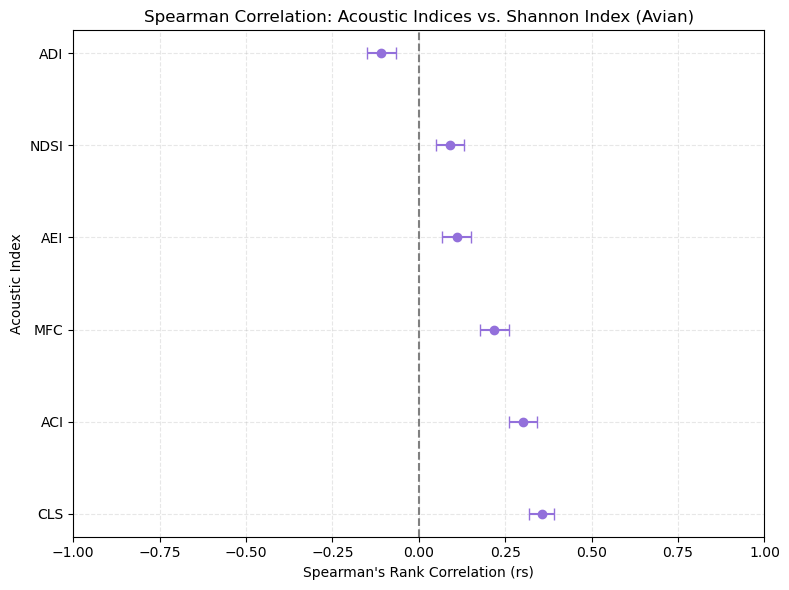

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ---------------------
# STEP 1: Load your data
# ---------------------
# Replace this with your actual dataset
# It should be a CSV or dataframe with at least 5 acoustic indices and one biodiversity column
# Here's a simulated placeholder:
data

# ---------------------------------
# STEP 2: Bootstrapped correlation
# ---------------------------------
def bootstrap_spearman(df, col_x, col_y, n_iterations=1000, random_seed=42):
    np.random.seed(random_seed)
    r_values = []
    for _ in range(n_iterations):
        sample = df.sample(frac=1, replace=True)
        r, _ = spearmanr(sample[col_x], sample[col_y])
        r_values.append(r)

    r_values = np.array(r_values)
    mean_r = np.mean(r_values)
    ci_lower = np.percentile(r_values, 2.5)
    ci_upper = np.percentile(r_values, 97.5)
    
    return mean_r, ci_lower, ci_upper

# -------------------------------------------------
# STEP 3: Loop through each index and compute stats
# -------------------------------------------------
indices = ['MFC', 'CLS', 'ADI', 'ACI', 'AEI', 'NDSI']  # replace or extend this list as needed
results = []

for index in indices:
    mean_r, ci_lower, ci_upper = bootstrap_spearman(data, index, 'shanon')
    results.append({
        'Index': index,
        'Mean_r': mean_r,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper
    })

df_results = pd.DataFrame(results).sort_values('Mean_r')

# ----------------------
# STEP 4: Plotting graph
# ----------------------
plt.figure(figsize=(8, 6))
plt.errorbar(df_results['Mean_r'], df_results['Index'],
             xerr=[df_results['Mean_r'] - df_results['CI_lower'], 
                   df_results['CI_upper'] - df_results['Mean_r']],
             fmt='o', color='mediumpurple', capsize=4)

plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Spearman's Rank Correlation (rs)")
plt.ylabel("Acoustic Index")
plt.title("Spearman Correlation: Acoustic Indices vs. Shannon Index (Avian)")
plt.xlim(-1, 1)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()